In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
from cStringIO import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time
import os.path
from os import path


In [2]:
dataType = "midMDwarfsHUw1649c"
outputDir = dataType + "Output/"

htmlLabel = dataType


if (dataType == "midMDwarfsBerger2019") | (dataType == "midMDwarfsBerger2019Large"):
    stellarCatalog = "stellarCatalogs/dr25_Berger2019_stellar_clean.txt"
elif (dataType == "midMDwarfsHU") | (dataType == "midMDwarfsHU10d") | (dataType == "midMDwarfsHUw1649c") | (dataType == "midMDwarfsHU10dNoVE"):
    stellarCatalog = "stellarCatalogs/dr25_HU_stellar_clean.txt"
else:
    raise ValueError('bad dataType');

if (dataType == "midMDwarfsBerger2019") | (dataType == "midMDwarfsBerger2019Large"):
    pcCatalog = "koiCatalogs/dr25_GK_PCs_midMDwarfsBerger2019.csv"
elif (dataType == "midMDwarfsHU") | (dataType == "midMDwarfsHU10d") | (dataType == "midMDwarfsHU10dNoVE"):
    pcCatalog = "koiCatalogs/dr25_GK_PCs_midMDwarfsHU.csv"
elif dataType == "midMDwarfsHUw1649c":
    pcCatalog = "koiCatalogs/dr25_GK_PCs_midMDwarfsHU.csv"
    koiCatalog = "koiCatalogs/dr25_GK_KOIs_midMDwarfsHU.csv"
else:
    raise ValueError('bad dataType');


if (dataType == "midMDwarfsHU10d") | (dataType == "midMDwarfsHU10dNoVE"):
    period_rng = (0.5, 10)
else:
    period_rng = (0.5, 30)
n_period = 57
rp_rng = (0.5, 11)
n_rp = 61

# for quick tests
# nWalkers = 6
# nBurnin = 200
# nMcmc = 1000
# for production runs
nWalkers = 16
nBurnin = 1000
nMcmc = 5000


model = "dualPowerLaw"
whichRadii = "corrected"

In [3]:

def rateModel(x, y, xRange, yRange, theta, model):
    if model == "dualPowerLaw":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1))
    elif model == "dualPowerLawGap":
        f0, alpha, beta, gd, gw, gapOffset, gapSlope = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
#        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    elif model == "dualPowerLawGapFixedSlope":
        f0, alpha, beta, gd, gw, gapOffset = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    elif model == "dualPowerLawFixedValley":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
        gd = 0.29297043
        gw = 0.14683756
        gapSlope = 0
        gapOffset = 0.29125824

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    else:
        raise ValueError('Bad model name');
        
    return r

def getModelLabels(model):
    if model == "dualPowerLaw":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    elif model == "dualPowerLawGap":
        return [r"$F_0$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$", r"$o_g$", r"$s_g$"]
    elif model == "dualPowerLawGapFixedSlope":
        return [r"$F_0$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$", r"$o_g$"]
    elif model == "dualPowerLawFixedValley":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    else:
        raise ValueError('Bad model name');

def initRateModel(model):
    if model == "dualPowerLaw":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    elif model == "dualPowerLawGap":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.1
        go = 0.26
        gs = 0.0
        theta = [f0, alpha, beta, gd, gw, go, gs]
    elif model == "dualPowerLawGapFixedSlope":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.1
        go = 0.26
        theta = [f0, alpha, beta, gd, gw, go]
    elif model == "dualPowerLawFixedValley":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    else:
        raise ValueError('Bad model name');
  
    return theta

def lnPoisprior(theta, model):
    if model == "dualPowerLaw":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0:
            return 1.0
    elif model == "dualPowerLawGap":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0 \
        and 0 <= theta[3] < 5 \
        and 0.1 <= theta[4] < 0.3 \
        and 0.2 <= theta[5] < 0.4 \
        and -0.0 <= theta[6] < 0.05:
            return 1.0
    elif model == "dualPowerLawGapFixedSlope":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0 \
        and 0 <= theta[3] < 0.6 \
        and 0.1 <= theta[4] < 0.3 \
        and 0.2 <= theta[5] < 0.4:
            return 1.0
    elif model == "dualPowerLawFixedValley":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0:
            return 1.0
    else:
        raise ValueError('Bad model name');
        
    # print(theta)
    return -np.inf


In [4]:
def medianAndErrorbars(data):
    if data.ndim > 1:
        dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(data, [16, 50, 84],
                                                axis=0)))
        dataResult = list(dataResult)
        return dataResult
    else:
        v = np.percentile(data, [16, 50, 84])
        return [v[1], v[2]-v[1], v[1]-v[0]]


def printMedianAndErrorbars(data):
    e = medianAndErrorbars(data)
    if data.ndim > 1:
        print("printMedianAndErrorbars only works for 1D arrays")
    else:
        return "{:.3f}".format(e[0]) +"^{+" + "{:.3f}".format(e[1]) + "}_{-" + "{:.3f}".format(e[2]) + "}"



In [5]:
from scipy.integrate import romb

def integrate2DGrid(g, dx, dy):
    if g.shape[0]%2 == 0 or g.shape[1]%2 == 0:
        raise ValueError('integrate2DGrid requires a grid with odd number of points on a side');
    return romb(romb(g, dx), dy)

def integrateRateModel(periodRange, rpRange, theta, model):
    nPts = 2**5+1 # must be 2**n + 1
    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nPts), 
                                       np.linspace(rpRange[0], rpRange[1], nPts), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    
    if theta.ndim == 1:
        y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)
        return integrate2DGrid(y, dp, dr)
    else: # assume first dimension is array of thetas
        ret = np.zeros(theta.shape[0])
        if len(ret) > 100:
            f = FloatProgress(min=0, max=len(ret))
            display(f)

        for i in range(len(ret)):
            y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta[i,:], model)
            ret[i] = integrate2DGrid(y, dp, dr)
            if len(ret) > 100:
                f.value += 1
        return ret


def integratePopTimesComp(periodRange, rpRange, theta, model, compGrid):
    nP = compGrid.shape[0]
    nR = compGrid.shape[1]

    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nP), 
                                       np.linspace(rpRange[0], rpRange[1], nR), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)*compGrid
    return integrate2DGrid(y, dp, dr)






In [6]:
# population inference functions

def lnlike(theta):
    pop = rateModel(period_grid, rp_grid, period_rng, rp_rng, theta, model) * summedCompleteness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(rateModel(koi_periods, koi_rps, period_rng, rp_rng, theta, model))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
def lnprob(theta):
    lp = lnPoisprior(theta, model)
    if not np.isfinite(lp):
        return -np.inf

    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15


In [7]:
# population analysis functions

# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax):
#    print("in make_plot, pop_comp:")
#    print(pop_comp.shape)

    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
#    print("pop:")
#    print(pop.shape)
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    
    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), period_grid.shape[0], period_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))

    for i, p in enumerate(samples):
        pop[i] = rateModel(period_grid, rp_grid, period_rng, rp_rng, p, model)
        gamma_earth[i] = rateModel(365.25, 1.0, period_rng, rp_rng, p, model) * 365.
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over period.
    dx = 0.25
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    fsize = 18
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * summedCompleteness[None, :, :], rp, x, period, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp, x, period, ax)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$", fontsize = fsize)
    
    # Integrate over period.
    dx = 2
    x = np.arange(period_rng[0], period_rng[1] + dx, dx)
    n, _ = np.histogram(koi_periods, x)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    make_plot(np.swapaxes(pop * summedCompleteness[None, :, :], 1, 2), period, x, rp, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 79)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), period, x, rp, ax)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 0.27)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$; $\Delta P = 31.25\,\mathrm{days}$", fontsize = fsize)
    
                
    return gamma_earth, fig


In [8]:
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    if whichRadii == "corrected Minus 1Sigma":
        return catalog.corrected_prad - catalog.corrected_prad_err1
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string');

In [9]:
stellarTargets = pd.read_csv(stellarCatalog)
base_pcs = pd.read_csv(pcCatalog)
# missing Kepler-445 d = Koi-2704.03, not in DR25

if dataType == "midMDwarfsHUw1649c":
    # load the koi catalog to get 3138.02 = 1649 c
    base_kois = pd.read_csv(koiCatalog)
    koi02 = base_kois[base_kois.kepoi_name == "K03138.02"]
    # correct the properties from the 1649 c paper
    koi02.loc[:,"corrected_prad"] = 1.06
    koi02.loc[:,"totalReliability"] = 1
    koi02.loc[:,"koi_pdisposition"] = "CANDIDATE"
    base_pcs = base_pcs.append(koi02, ignore_index=True)
    
base_pcs.loc[base_pcs["kepoi_name"] == "K00961.03","totalReliability"] = 1
base_pcs.loc[base_pcs["kepoi_name"] == "K00961.01","totalReliability"] = 1
base_pcs.loc[base_pcs["kepoi_name"] == "K01702.01","totalReliability"] = 1
base_pcs.loc[base_pcs["kepoi_name"] == "K02842.01","totalReliability"] = 1
base_pcs.loc[base_pcs["kepoi_name"] == "K02842.02","totalReliability"] = 1
base_pcs.loc[base_pcs["kepoi_name"] == "K02842.03","totalReliability"] = 1
base_pcs.loc[base_pcs["kepoi_name"] == "K03138.01","totalReliability"] = 1
base_pcs.loc[base_pcs["kepoi_name"] == "K02704.01","totalReliability"] = 1
base_pcs.loc[base_pcs["kepoi_name"] == "K02704.02","totalReliability"] = 1
base_pcs.loc[base_pcs["kepoi_name"] == "K05327.01","totalReliability"] = 1
base_pcs.loc[base_pcs["kepoi_name"] == "K04290.01","totalReliability"] = 1
base_pcs.loc[base_pcs["kepoi_name"] == "K06863.01","totalReliability"] = 1

m = (period_rng[0] <= base_pcs.koi_period) & (base_pcs.koi_period <= period_rng[1])
thisRadii = getRadii(base_pcs)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
m &= base_pcs.totalReliability > .9
    
pcs = pd.DataFrame(base_pcs[m])
allPcs = pcs


/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
base_pcs

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,corrected_prad_err1,corrected_prad_err2,rowid,kepid_y,fpp_koi_period,fpp_prob,reliability,fpp_prob_use,totalReliability,Disp
0,8561063,K00961.03,2,CANDIDATE,1.000,1.865114,33.096786,0.66,0.17,-0.08,...,0.022670,-0.089316,1738,8561063,1.865,0.024000,1,0.024000,1.00,PC
1,8561063,K00961.01,1,CANDIDATE,1.000,1.213770,70.819550,0.78,0.20,-0.09,...,0.027342,-0.122816,1736,8561063,1.214,0.000060,1,0.000060,1.00,PC
2,7304449,K01702.01,1,CANDIDATE,0.999,1.538181,28.219137,1.00,0.23,-0.18,...,0.082524,-0.263465,2585,7304449,1.538,0.000870,1,0.000870,1.00,PC
3,8733898,K02842.01,1,CANDIDATE,1.000,1.565413,33.523926,1.73,0.22,-0.19,...,0.060015,-0.033992,3977,8733898,1.565,0.001000,1,0.001000,1.00,PC
4,8733898,K02842.02,3,CANDIDATE,0.992,5.148923,17.186102,1.72,0.21,-0.18,...,0.228572,-0.088887,3978,8733898,5.149,0.020000,1,0.020000,1.00,PC
5,8733898,K02842.03,2,CANDIDATE,0.947,3.036209,18.237106,1.40,0.17,-0.15,...,0.047261,-0.037074,3979,8733898,3.036,0.006500,1,0.006500,1.00,PC
6,6444896,K03138.01,1,CANDIDATE,1.000,8.689108,11.992775,0.49,0.00,0.00,...,0.067505,-0.043770,3907,6444896,8.689,0.360000,1,0.360000,1.00,PC
7,9730163,K02704.01,1,CANDIDATE,1.000,4.871224,41.956470,1.56,0.70,-0.23,...,0.300339,-0.252082,4015,9730163,4.871,0.000022,1,0.000022,1.00,PC
8,9730163,K02704.02,2,CANDIDATE,0.939,2.984158,19.508406,0.92,0.42,-0.14,...,0.059215,-0.111645,4016,9730163,2.984,0.004400,1,0.004400,1.00,PC
9,6776555,K05327.01,1,CANDIDATE,1.000,5.433613,12.448482,2.09,0.12,-0.28,...,0.074053,-0.064203,5628,6776555,5.434,0.010000,1,0.010000,1.00,PC


In [11]:
base_pcs.totalReliability

0     1.00
1     1.00
2     1.00
3     1.00
4     1.00
5     1.00
6     1.00
7     1.00
8     1.00
9     1.00
10    1.00
11    1.00
12    0.45
13    0.00
14    1.00
Name: totalReliability, dtype: float64

In [12]:
allPcs

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,corrected_prad_err1,corrected_prad_err2,rowid,kepid_y,fpp_koi_period,fpp_prob,reliability,fpp_prob_use,totalReliability,Disp
0,8561063,K00961.03,2,CANDIDATE,1.000,1.865114,33.096786,0.66,0.17,-0.08,...,0.022670,-0.089316,1738,8561063,1.865,0.024000,1,0.024000,1.0,PC
1,8561063,K00961.01,1,CANDIDATE,1.000,1.213770,70.819550,0.78,0.20,-0.09,...,0.027342,-0.122816,1736,8561063,1.214,0.000060,1,0.000060,1.0,PC
2,7304449,K01702.01,1,CANDIDATE,0.999,1.538181,28.219137,1.00,0.23,-0.18,...,0.082524,-0.263465,2585,7304449,1.538,0.000870,1,0.000870,1.0,PC
3,8733898,K02842.01,1,CANDIDATE,1.000,1.565413,33.523926,1.73,0.22,-0.19,...,0.060015,-0.033992,3977,8733898,1.565,0.001000,1,0.001000,1.0,PC
4,8733898,K02842.02,3,CANDIDATE,0.992,5.148923,17.186102,1.72,0.21,-0.18,...,0.228572,-0.088887,3978,8733898,5.149,0.020000,1,0.020000,1.0,PC
5,8733898,K02842.03,2,CANDIDATE,0.947,3.036209,18.237106,1.40,0.17,-0.15,...,0.047261,-0.037074,3979,8733898,3.036,0.006500,1,0.006500,1.0,PC
6,6444896,K03138.01,1,CANDIDATE,1.000,8.689108,11.992775,0.49,0.00,0.00,...,0.067505,-0.043770,3907,6444896,8.689,0.360000,1,0.360000,1.0,PC
7,9730163,K02704.01,1,CANDIDATE,1.000,4.871224,41.956470,1.56,0.70,-0.23,...,0.300339,-0.252082,4015,9730163,4.871,0.000022,1,0.000022,1.0,PC
8,9730163,K02704.02,2,CANDIDATE,0.939,2.984158,19.508406,0.92,0.42,-0.14,...,0.059215,-0.111645,4016,9730163,2.984,0.004400,1,0.004400,1.0,PC
9,6776555,K05327.01,1,CANDIDATE,1.000,5.433613,12.448482,2.09,0.12,-0.28,...,0.074053,-0.064203,5628,6776555,5.434,0.010000,1,0.010000,1.0,PC


(0.5, 30)

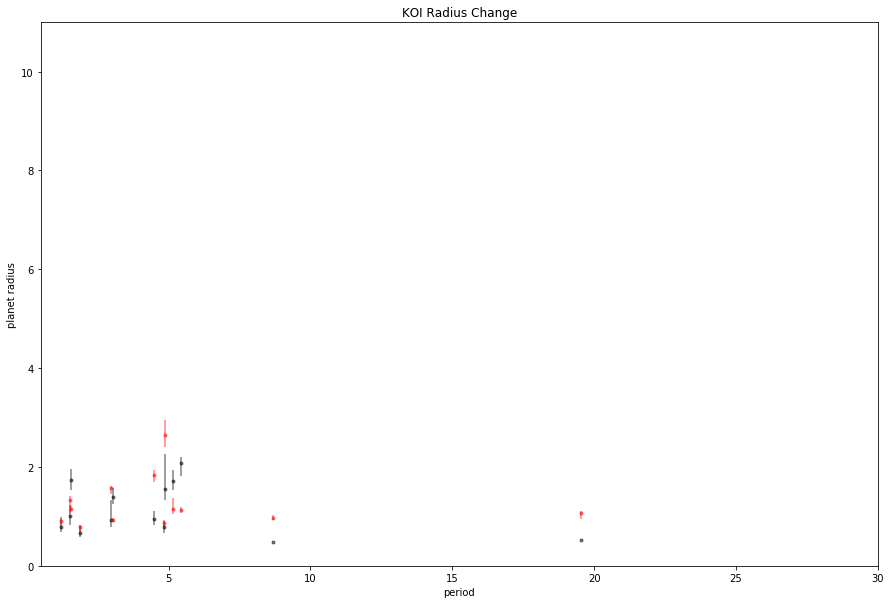

In [13]:
fig, ax = plt.subplots(figsize=(15,10));
ax.errorbar(pcs.koi_period, pcs.koi_prad, 
            yerr = [-pcs.koi_prad_err2, pcs.koi_prad_err1],
            fmt="k.", alpha = 0.5);
ax.errorbar(pcs.koi_period, pcs.corrected_prad, 
            yerr = [-pcs.corrected_prad_err2, pcs.corrected_prad_err1],
            fmt="r.", alpha = 0.5);

plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Radius Change");
plt.ylim([0, 11])
plt.xlim([0.5, 30])




In [14]:
period = np.linspace(period_rng[0], period_rng[1], n_period)
rp = np.linspace(rp_rng[0], rp_rng[1], n_rp)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
periodShape = period_grid.shape



In [15]:
if dataType == "midMDwarfsBerger2019":
    inputgrid = "midMDwarfsBerger2019Output/contour_midMDwarfsBerger2019Output.fits.gz"
elif dataType == "midMDwarfsBerger2019Large":
    inputgrid = "midMDwarfsBerger2019LargeOutput/contour_midMDwarfsBerger2019Output.fits.gz"
elif (dataType == "midMDwarfsHU") | (dataType == "midMDwarfsHUw1649c"):
    inputgrid = "midMDwarfsHUOutput/contour_midMDwarfsHUOutput.fits.gz"
elif (dataType == "midMDwarfsHU10d"):
    inputgrid = "midMDwarfsHU10dOutput/contour_midMDwarfsHU10dOutput.fits.gz"
elif (dataType == "midMDwarfsHU10dNoVE"):
    inputgrid = "midMDwarfsHU10dNoVEOutput/contour_midMDwarfsHUNoVEOutput.fits.gz"

print("inputgrid = " + inputgrid)

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
# print "KIC list length" + '{:6d}'.format(kiclist.size)

period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

# interpolate the numerical grids onto the period_grid, rp_grid space
#print("size probtot = " + str(np.shape(probtot)))
#print("size period_want = " + str(np.shape(period_want)))
#print("size rp_want = " + str(np.shape(rp_want)))

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
numProbDetInterp = RectBivariateSpline(period_want, rp_want, probdet)



inputgrid = midMDwarfsHUOutput/contour_midMDwarfsHUOutput.fits.gz


In [16]:
summedCompleteness = numCompVeInterp(period, rp)
summedProbDet = numProbDetInterp(period, rp)





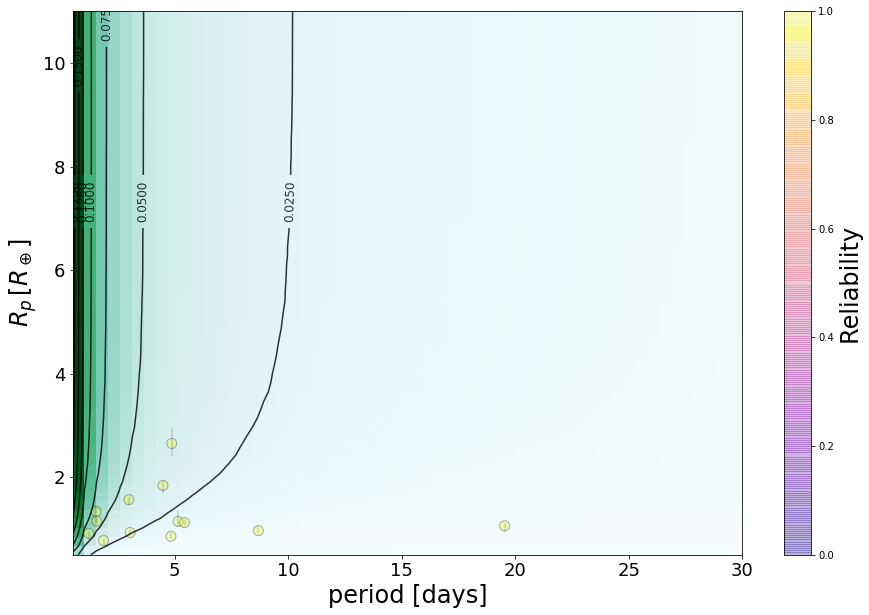

In [17]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
# contourLevels = np.arange(1e-3, 1e-2, 1e-3)
# contourLevels = np.insert(contourLevels, 0, [1e-4, 5e-4])
contourLevels = np.arange(0.004, 0.004, 0.032)

fig, ax = plt.subplots(figsize=(15,10));

plt.pcolor(period_grid, rp_grid, summedCompleteness, cmap="BuGn")
#c = plt.contour(period_grid, rp_grid, summedCompleteness / kiclist.size, contourLevels,
#               colors="k", alpha=0.8)
c = plt.contour(period_grid, rp_grid, summedCompleteness / kiclist.size,
               colors="k", alpha=0.8)
ax.errorbar(pcs.koi_period, getRadii(pcs), 
            yerr = [-pcs.corrected_prad_err2, pcs.corrected_prad_err1],
            fmt="none", ecolor="k", alpha = 0.15, marker = None);
scf = plt.scatter(pcs.koi_period, getRadii(pcs), cmap="plasma", 
               c=pcs.totalReliability, edgecolors='k', s=100*pcs.totalReliability, alpha = 0.3)
plt.clim(0,1)
cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability", fontsize = 24);

#c = plt.contour(period_grid, rp_grid, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
plt.ylim(0.5, 11)
plt.xlim(0.5, 30)
plt.clabel(c, fontsize=12, inline=1, fmt="%.4f")
# plt.title("DR25 PC Average detection*vetting efficiency", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.xlabel("period [days]", fontsize = 24)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 24);




In [18]:
1.2*365

438.0

Compute a basic occurrence rate without reliability

[ 2.73518669 -0.03652803 -2.75037368]


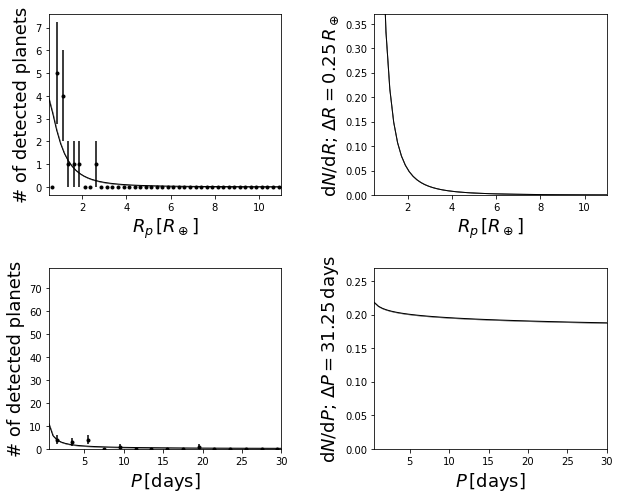

In [19]:
pcs = allPcs

if model == "dualPowerLaw":
    bounds = [(0, 5), (-5, 5), (-5, 5)]
elif model == "dualPowerLawGap":
    bounds = [(0, 5), (-5, 5), (-5, 5), (0, 5), (0.0, 0.3), (0.2, 0.4), (-0.2, 0.2)]
elif model == "dualPowerLawGapFixedSlope":
    bounds = [(0, 5), (-5, 5), (-5, 5), (0, 5), (0.0, 0.3), (0.2, 0.4)]
elif model == "dualPowerLawFixedValley":
    bounds = [(0, 5), (-5, 5), (-5, 5)]
    
# The ln-likelihood function given at the top of this post.
koi_periods = np.array(pcs.koi_period)
koi_rps = np.array(getRadii(pcs))
# koi_rps = getRadii(pcs)


vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]

theta_0 = initRateModel(model)
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r.x)
ge, fig = plot_results(r.x);



In [20]:
rateModel(365.25, 1.0, period_rng, rp_rng, r.x, model)*365

15.595423865554574

In [21]:

##################################################################


ndim, nwalkers = len(r.x), nWalkers
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, nBurnin)
sampler.reset()

# Production.
start_time = time.time()
pos, _, _ = sampler.run_mcmc(pos, nMcmc)
print("--- %s seconds ---" % (time.time() - start_time))

samples_noreliability = sampler.flatchain   


--- 25.2572629452 seconds ---


25.828967112973707


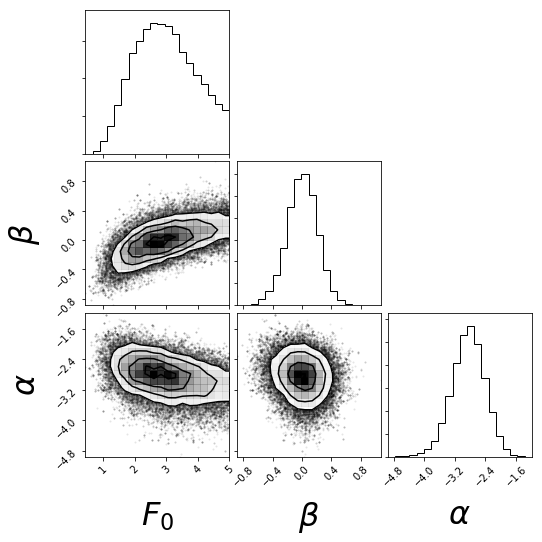

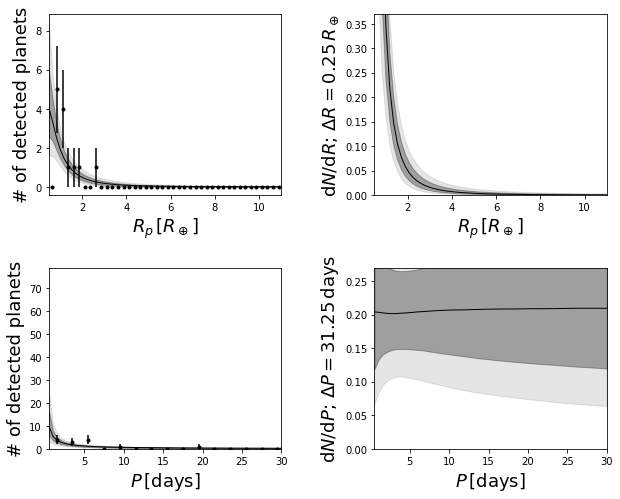

In [22]:
##################################################################
##################################################################

corner.corner(samples_noreliability, labels=getModelLabels(model), label_kwargs = {"fontsize": 32});

##################################################################

gamma_earth_no_reliability, fig = plot_results(samples_noreliability)
print(np.mean(gamma_earth_no_reliability))

##################################################################



In [23]:
print("F0 = " + printMedianAndErrorbars(samples_noreliability[:,0]))
print("radius exp (alpha) = " + printMedianAndErrorbars(samples_noreliability[:,2]))
print("period exp (beta) = " + printMedianAndErrorbars(samples_noreliability[:,1]))





F0 = 2.926^{+1.106}_{-0.948}
radius exp (alpha) = -2.839^{+0.410}_{-0.432}
period exp (beta) = 0.003^{+0.200}_{-0.206}


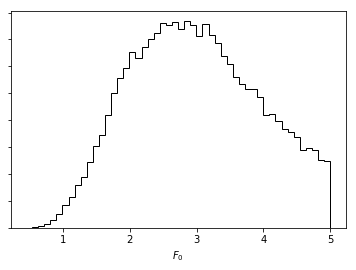

In [24]:

plt.hist(samples_noreliability[:,0], 50, histtype="step", color="k", density=True)
plt.gca().set_yticklabels([])
plt.xlabel(r"$F_0$");




Compute an occurrence rate with reliability

In [25]:
nTrials = 1000


postName = outputDir + "occurenceRatePosteriors_uncertainty.npy"
if path.exists(postName): 
    samplesRadiiSigma = np.load(postName)
    ndim = samplesRadiiSigma.shape[1]
else:
    f = FloatProgress(min=0, max=nTrials)
    display(f)
    koiRadii0 = getRadii(allPcs)
    periodSelect = (period_rng[0] <= allPcs.koi_period) & (allPcs.koi_period <= period_rng[1])
    for mCount in range(nTrials):
        # randomly change the koi radius
        # randomly choose half to be modified w/ upper error, half w/ lower error
        errorSelect = np.random.rand(len(allPcs)) < 0.5
        # add the sampled error to the radii
        # upper error bar
        thisRadii = np.zeros(koiRadii0.shape)
        thisRadii[errorSelect] = koiRadii0[errorSelect] \
                       + np.abs(np.random.normal(0.0, allPcs['corrected_prad_err1'][errorSelect], sum(errorSelect)))
        # lower error bar
        thisRadii[~errorSelect] = koiRadii0[~errorSelect] \
                       - np.abs(np.random.normal(0.0, -allPcs['corrected_prad_err2'][~errorSelect], sum(~errorSelect)))
        # select on period and radius in range
        m = periodSelect & np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])

        koi_periods = np.array(allPcs[m].koi_period)
        koi_rps = np.array(thisRadii[m])

        theta_0 = initRateModel(model)
        r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)

        ##################################################################


        ndim, nwalkers = len(r.x), 2*len(r.x)
        pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

        # Burn in.
        pos, _, _ = sampler.run_mcmc(pos, 400)
        sampler.reset()

        # Production.
        pos, _, _ = sampler.run_mcmc(pos, 2000)

        samples = sampler.flatchain   
        if mCount == 0:
            samplesRadiiSigma = samples[:-1:10,:]
            allRadii = koi_rps;
            allRadii0 =  koiRadii0[m];
        else:
            samplesRadiiSigma = np.concatenate((samplesRadiiSigma, samples[:-1:10,:]))
            allRadii = np.concatenate((allRadii, koi_rps))
            allRadii0 = np.concatenate((allRadii0, koiRadii0[m]))

        f.value += 1


    np.save(postName, samplesRadiiSigma)


FloatProgress(value=0.0, max=1000.0)

/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [26]:
samplesRadiiSigma.shape

(1200000, 3)

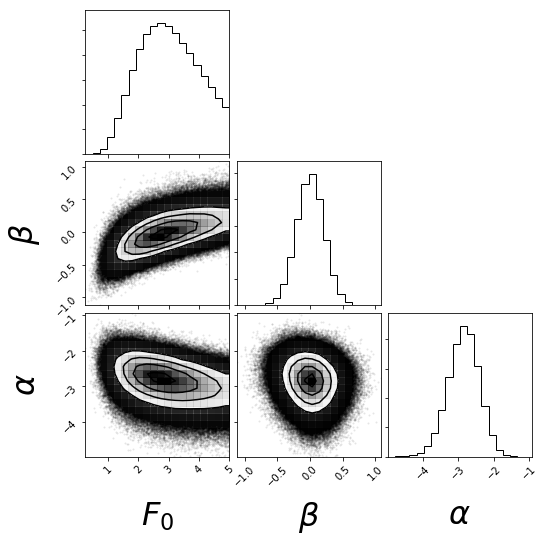

In [27]:
corner.corner(samplesRadiiSigma, labels=getModelLabels(model), label_kwargs = {"fontsize": 32});
plt.savefig(outputDir + "occPostReliability_uncertainty.pdf",bbox_inches='tight')




In [28]:
modelLabels = getModelLabels(model)
for i in range(0,ndim):
    print("MCMC no reliability " + modelLabels[i] + "=" + printMedianAndErrorbars(samples_noreliability[:,i]))
for i in range(0,ndim):
    print("MCMC with reliability " + modelLabels[i] + "=" + printMedianAndErrorbars(samplesRadiiSigma[:,i]))


MCMC no reliability $F_0$=2.926^{+1.106}_{-0.948}
MCMC no reliability $\beta$=0.003^{+0.200}_{-0.206}
MCMC no reliability $\alpha$=-2.839^{+0.410}_{-0.432}
MCMC with reliability $F_0$=2.972^{+1.111}_{-0.965}
MCMC with reliability $\beta$=0.004^{+0.208}_{-0.213}
MCMC with reliability $\alpha$=-2.838^{+0.412}_{-0.444}


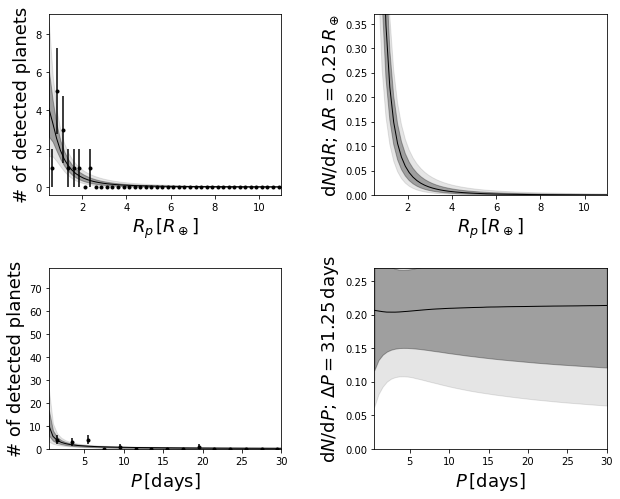

In [29]:
gamma_earth, fig = plot_results(samplesRadiiSigma[:-1:10,:])
plt.savefig(outputDir + "occMargReliability_uncertainty.pdf",bbox_inches='tight')


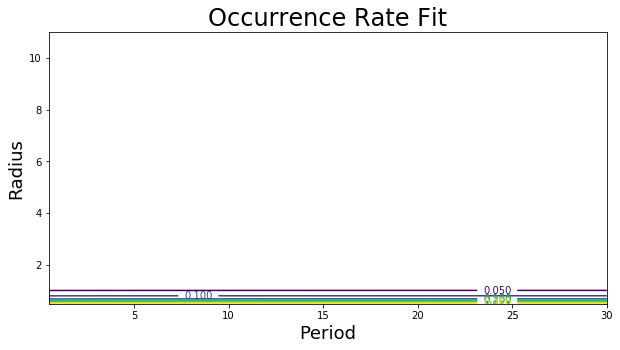

In [30]:
fig, ax = plt.subplots(figsize=(10,5));
rateGrid = rateModel(period_grid, rp_grid, period_rng, rp_rng, np.median(samplesRadiiSigma, 0), model)
CS = ax.contour(period_grid, rp_grid, rateGrid);
ax.clabel(CS, inline=1, fontsize=10);
plt.xlabel("Period", fontsize = 18);
plt.ylabel("Radius", fontsize = 18);
plt.title("Occurrence Rate Fit", fontsize = 24);


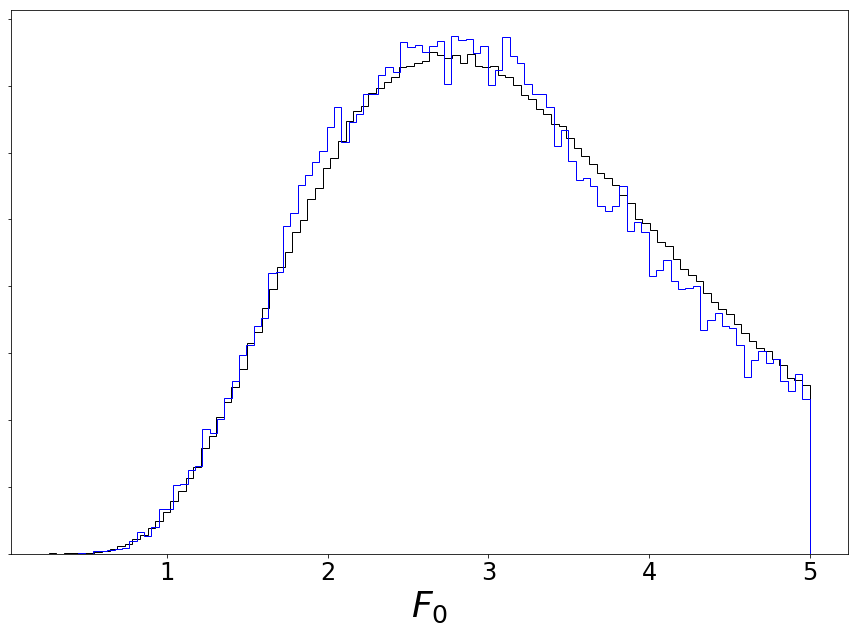

In [31]:
plt.figure(figsize=(15,10));
plt.hist(samplesRadiiSigma[:,0], 100, histtype="step", color="k", density=True)
plt.hist(samples_noreliability[:,0], 100, histtype="step", color="b", density=True)
plt.gca().set_yticklabels([])
plt.xlabel(r"$F_0$", fontSize = 36);
plt.tick_params(labelsize = 24)
plt.savefig(outputDir + "F0Dist_uncertainty.pdf",bbox_inches='tight')


In [32]:
hzDist = integrateRateModel([15,25], [0.75, 1.5], samplesRadiiSigma, model)
hzDistNR = integrateRateModel([15,25], [0.75, 1.5], samples_noreliability, model)

FloatProgress(value=0.0, max=1200000.0)

FloatProgress(value=0.0, max=80000.0)

0.75-1.5 Re, 15-25 Days = 0.337^{+0.147}_{-0.126}
no reliability: 0.5-2.5 Re, 0.5-10 Days = 0.331^{+0.146}_{-0.122}


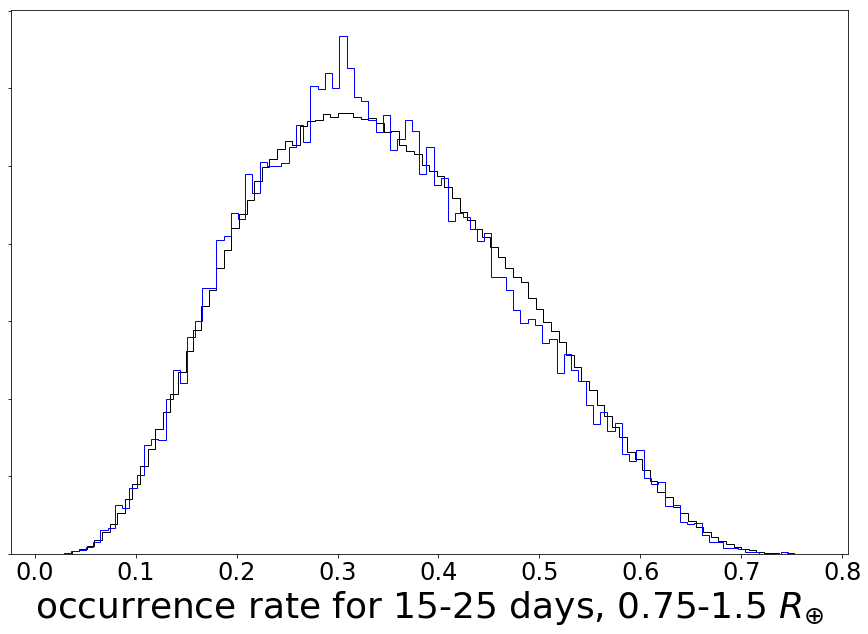

In [33]:

plt.figure(figsize=(15,10));
plt.hist(hzDist, 100, histtype="step", color="k", density=True)
plt.hist(hzDistNR, 100, histtype="step", color="b", density=True)
plt.gca().set_yticklabels([])
plt.xlabel(r"occurrence rate for 15-25 days, 0.75-1.5 $R_{\oplus}$" , fontSize = 36);
plt.tick_params(labelsize = 24)
plt.savefig(outputDir + "hzDist_uncertainty.pdf",bbox_inches='tight')

print("0.75-1.5 Re, 15-25 Days = " + printMedianAndErrorbars(hzDist))
print("no reliability: 0.5-2.5 Re, 0.5-10 Days = " + printMedianAndErrorbars(hzDistNR))


Hardegree-Ullman occurrence rate

In [34]:
huDist = integrateRateModel([0.5,10], [0.5, 2.5], samplesRadiiSigma, model)
huDistNR = integrateRateModel([0.5,10], [0.5, 2.5], samples_noreliability, model)

FloatProgress(value=0.0, max=1200000.0)

FloatProgress(value=0.0, max=80000.0)

0.5-2.5 Re, 0.5-10 Days = 0.881^{+0.270}_{-0.239}
no reliability: 0.5-2.5 Re, 0.5-10 Days = 0.872^{+0.269}_{-0.237}


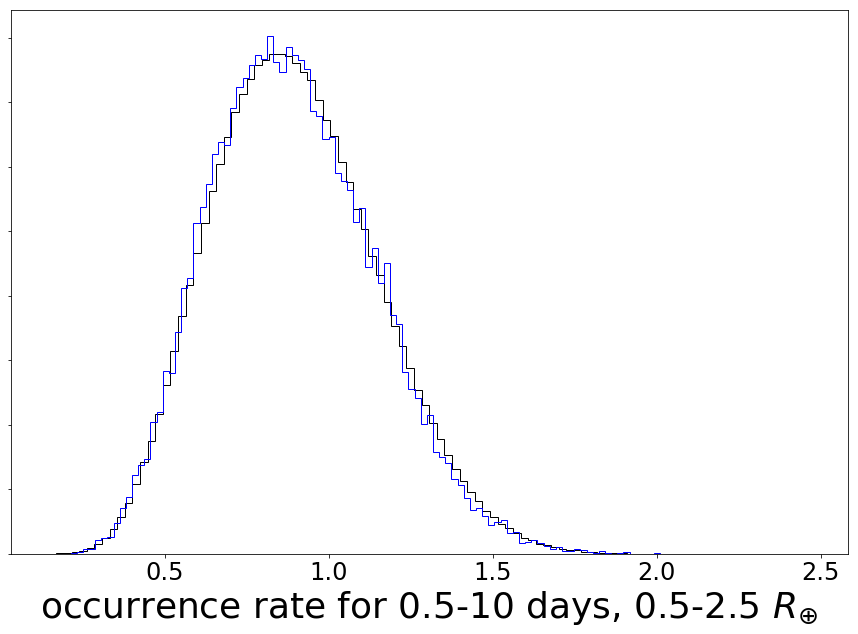

In [35]:
plt.figure(figsize=(15,10));
plt.hist(huDist, 100, histtype="step", color="k", density=True)
plt.hist(huDistNR, 100, histtype="step", color="b", density=True)
plt.gca().set_yticklabels([])
plt.xlabel(r"occurrence rate for 0.5-10 days, 0.5-2.5 $R_{\oplus}$" , fontSize = 36);
plt.tick_params(labelsize = 24)
plt.savefig(outputDir + "huDist_uncertainty.pdf",bbox_inches='tight')

print("0.5-2.5 Re, 0.5-10 Days = " + printMedianAndErrorbars(huDist))
print("no reliability: 0.5-2.5 Re, 0.5-10 Days = " + printMedianAndErrorbars(huDistNR))


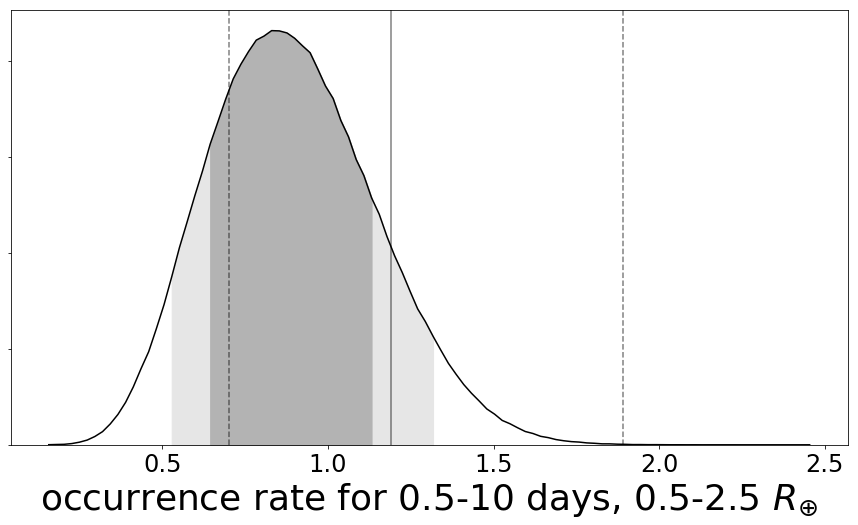

In [36]:
plt.figure(figsize=(15,8));
confDat84 = np.percentile(huDist, [16, 50, 84]);
confDat95 = np.percentile(huDist, [5, 50, 95]);
hDat = np.histogram(huDist, 100);
valX = (hDat[1][0:-1] + hDat[1][1:])/2;
valY = hDat[0];

plt.plot(valX, valY, 'k')
#plt.fill_between(valX, valY, color = [.95, .95, .95])
fillIdx95 = (valX >= confDat95[0]) & (valX <= confDat95[2])
plt.fill_between(valX[fillIdx95], valY[fillIdx95], color = [.9, .9, .9])
fillIdx84 = (valX >= confDat84[0]) & (valX <= confDat84[2])
plt.fill_between(valX[fillIdx84], valY[fillIdx84], color = [.7, .7, .7])
yl = plt.ylim();
plt.ylim(0, yl[1])
plt.plot([1.19, 1.19], plt.ylim(), 'k', alpha=0.5)
plt.plot([1.19+.7, 1.19+.7], plt.ylim(), 'k--', alpha=0.5)
plt.plot([1.19-.49, 1.19-.49], plt.ylim(), 'k--', alpha=0.5)

plt.xlabel(r"occurrence rate for 0.5-10 days, 0.5-2.5 $R_{\oplus}$" , fontSize = 36);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.savefig(outputDir + "huDist_shaded_uncertainty.pdf",bbox_inches='tight')


In [37]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [38]:
%%bash -s  "$htmlLabel"
jupyter nbconvert --to html computeOccurrence_uncertainty.ipynb
mv computeOccurrence_uncertainty.html htmlArchive/computeOccurrence_uncertainty_$1.html

[NbConvertApp] Converting notebook computeOccurrence_uncertainty.ipynb to html
[NbConvertApp] Writing 1065779 bytes to computeOccurrence_uncertainty.html


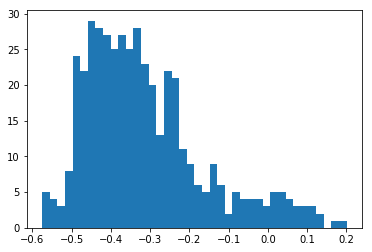

In [39]:
plt.hist(stellarTargets.cdppslplong, 40);

In [40]:
list(stellarTargets)

['kepid',
 'tm_designation',
 'teff',
 'teff_err1',
 'teff_err2',
 'logg',
 'logg_err1',
 'logg_err2',
 'feh',
 'feh_err1',
 'feh_err2',
 'mass',
 'mass_err1',
 'mass_err2',
 'radius',
 'radius_err1',
 'radius_err2',
 'dens',
 'dens_err1',
 'dens_err2',
 'prov_sec',
 'kepmag',
 'limbdark_coeff1',
 'limbdark_coeff2',
 'limbdark_coeff3',
 'limbdark_coeff4',
 'dist',
 'dist_err1',
 'dist_err2',
 'nconfp',
 'nkoi',
 'ntce',
 'datalink_dvr',
 'st_delivname',
 'st_vet_date_str',
 'ra',
 'dec',
 'st_quarters',
 'teff_prov',
 'logg_prov',
 'feh_prov',
 'jmag',
 'jmag_err',
 'hmag',
 'hmag_err',
 'kmag',
 'kmag_err',
 'dutycycle',
 'dataspan',
 'mesthres01p5',
 'mesthres02p0',
 'mesthres02p5',
 'mesthres03p0',
 'mesthres03p5',
 'mesthres04p5',
 'mesthres05p0',
 'mesthres06p0',
 'mesthres07p5',
 'mesthres09p0',
 'mesthres10p5',
 'mesthres12p0',
 'mesthres12p5',
 'mesthres15p0',
 'rrmscdpp01p5',
 'rrmscdpp02p0',
 'rrmscdpp02p5',
 'rrmscdpp03p0',
 'rrmscdpp03p5',
 'rrmscdpp04p5',
 'rrmscdpp05p0',


0.5-2.5 Re, 0.5-10 Days = 0.881^{+0.270}_{-0.239}
no reliability: 0.5-2.5 Re, 0.5-10 Days = 0.872^{+0.269}_{-0.237}


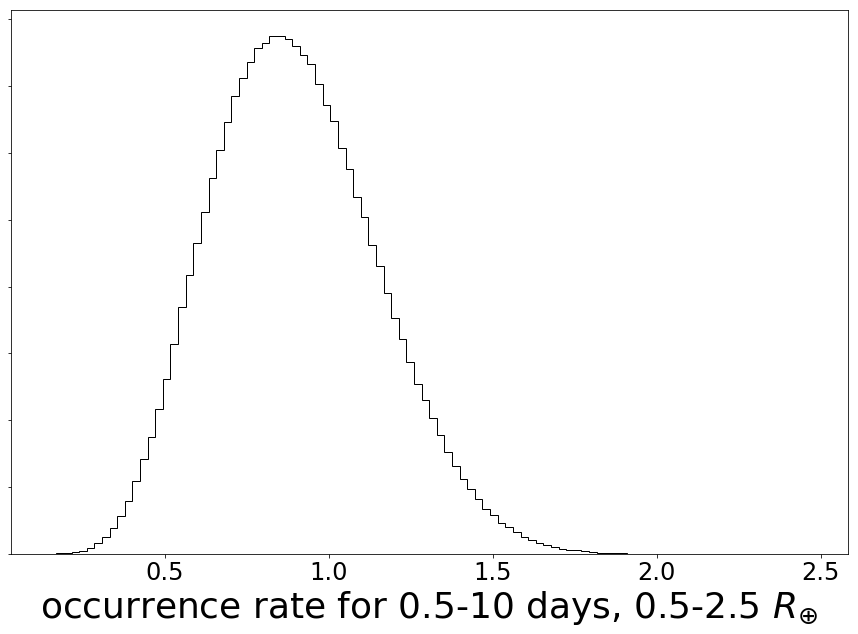

In [41]:
plt.figure(figsize=(15,10));
plt.hist(huDist, 100, histtype="step", color="k", density=True)
plt.gca().set_yticklabels([])
plt.xlabel(r"occurrence rate for 0.5-10 days, 0.5-2.5 $R_{\oplus}$" , fontSize = 36);
plt.tick_params(labelsize = 24)

print("0.5-2.5 Re, 0.5-10 Days = " + printMedianAndErrorbars(huDist))
print("no reliability: 0.5-2.5 Re, 0.5-10 Days = " + printMedianAndErrorbars(huDistNR))


In [42]:
(hDat[1][0:-1] + hDat[1][1:])/2

array([0.15656312, 0.17977921, 0.2029953 , 0.22621139, 0.24942748,
       0.27264356, 0.29585965, 0.31907574, 0.34229183, 0.36550792,
       0.38872401, 0.4119401 , 0.43515619, 0.45837228, 0.48158836,
       0.50480445, 0.52802054, 0.55123663, 0.57445272, 0.59766881,
       0.6208849 , 0.64410099, 0.66731708, 0.69053317, 0.71374925,
       0.73696534, 0.76018143, 0.78339752, 0.80661361, 0.8298297 ,
       0.85304579, 0.87626188, 0.89947797, 0.92269406, 0.94591014,
       0.96912623, 0.99234232, 1.01555841, 1.0387745 , 1.06199059,
       1.08520668, 1.10842277, 1.13163886, 1.15485494, 1.17807103,
       1.20128712, 1.22450321, 1.2477193 , 1.27093539, 1.29415148,
       1.31736757, 1.34058366, 1.36379975, 1.38701583, 1.41023192,
       1.43344801, 1.4566641 , 1.47988019, 1.50309628, 1.52631237,
       1.54952846, 1.57274455, 1.59596064, 1.61917672, 1.64239281,
       1.6656089 , 1.68882499, 1.71204108, 1.73525717, 1.75847326,
       1.78168935, 1.80490544, 1.82812152, 1.85133761, 1.87455

In [43]:
np.shape(hDat[1][0:-1])

(100,)

In [44]:
base_pcs.corrected_prad

0     0.775331
1     0.914801
2     1.337084
3     1.150325
4     1.143485
5     0.929603
6     0.966141
7     2.651388
8     1.565378
9     1.122740
10    0.856527
11    1.840679
12    0.834013
13    0.686732
14    1.060000
Name: corrected_prad, dtype: float64

In [45]:
base_pcs.corrected_prad_err1

0      0.022670
1      0.027342
2      0.082524
3      0.060015
4      0.228572
5      0.047261
6      0.067505
7      0.300339
8      0.059215
9      0.074053
10     0.067777
11     0.092619
12     0.024982
13    12.781702
14     0.048357
Name: corrected_prad_err1, dtype: float64

In [46]:
base_pcs.corrected_prad_err2

0    -0.089316
1    -0.122816
2    -0.263465
3    -0.033992
4    -0.088887
5    -0.037074
6    -0.043770
7    -0.252082
8    -0.111645
9    -0.064203
10   -0.054183
11   -0.145861
12   -0.024982
13   -0.246530
14   -0.118388
Name: corrected_prad_err2, dtype: float64

In [47]:
base_pcs.koi_period

0      1.865114
1      1.213770
2      1.538181
3      1.565413
4      5.148923
5      3.036209
6      8.689108
7      4.871224
8      2.984158
9      5.433613
10     4.838095
11     4.485592
12    34.573719
13     0.995141
14    19.535255
Name: koi_period, dtype: float64

In [48]:
base_pcs.kepoi_name

0     K00961.03
1     K00961.01
2     K01702.01
3     K02842.01
4     K02842.02
5     K02842.03
6     K03138.01
7     K02704.01
8     K02704.02
9     K05327.01
10    K04290.01
11    K06863.01
12    K08012.01
13    K06705.01
14    K03138.02
Name: kepoi_name, dtype: object